# Homework #2 - Linear Models. gradient descent

In this homework assignment, you and I will learn how to train linear regression and classification models using a very powerful, but at the same time quite understandable algorithm called **gradient descent**. In addition to linear models, it is also used to train the most complex neural networks! We will also practice using ready-made implementations of linear models for regression and binary classification problems.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                            roc_auc_score,
                            log_loss,
                            accuracy_score,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            balanced_accuracy_score,
                            roc_curve)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Small theoretical digression

The main property of the anti-gradient (-1 * gradient) is that it points in the direction of the fastest decrease in the function at a given point. Accordingly, it would be logical to start from a certain point, move towards the anti-gradient, recalculate the anti-gradient and move towards it again, etc. Let's write this more formally. 

Let $w_0$ be the initial set of parameters (linear model coefficients) ((for example, zero or generated from some random distribution)). 

Then the usual gradient descent is to repeat the following steps until convergence: $$ w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}), $$ where $\nabla_{w} Q(w_{k})$ is the gradient of the loss function at point $w_k$, and $\eta$ is the learning rate. Gradient descent is usually stopped when the specified maximum number of iterations has passed, or when the graph is close to zero (i.e. our parameters are practically unchanged). To implement the second option, consider the norm of the gradient (essentially the length of the vector). This can be done in several ways: $$ l1_{norm} = \sum{|w_i|} $$ $$ l2_{norm} = \sum{(w_i)^{2}} $$ Let's try to figure it out with a simple example. Consider a function of two variables: $f(x, y) = \sin^2 x + \sin^2 y$


In [8]:
def f(w):
    """
    :param w: np.array(np.float) 2 element vector
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Note that $x$ is a numpy-array vector of length 2.

***Reminder:***  

What do we want? We want to find the minimum of this function (in machine learning, we usually want to find the minimum of the **loss function**, for example, MSE), or rather find $w_1$ and $w_2$ such that the value of $f(w_1, w_2)$ is minimal for them, that is, the *extremum point*. 

How are we going to find this point? We use optimization methods (in our case - *minimization*). One such method is **gradient descent**.

### Task 1. Gradient descent for the function $f$

Implement a function that will perform gradient descent for the $f$ function: 

*Note:* You need to calculate partial derivatives exactly **analytically** and **rewrite them in code**, and not calculate derivatives numerically (through the ratio of the increment of the function to the increment of the argument) - in these two cases, the answers may differ, so be careful.


In [9]:
def grad_f(w): 
    """
    The gradient of the function f defined above. 
        :param w: np.array[2]: float vector of 2 elements 
        :return: np.array[2]: float vector of 2 elements

    """
    grad = 2*np.cos(w)*np.sin(w)
    return grad
grad_f(np.array([1, 2]))

array([ 0.90929743, -0.7568025 ])

Let's check that the gradient takes a vector of two numbers and gives the correct value at this point

In [10]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [11]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    A function that implements gradient descent to the minimum for a function f of two variables. 
        :param f: scalar function of two variables 
        :param grad_f: a function that returns the gradient of function f (
                        arranged as you implemented grad_f above) 
        :param lr: algorithm learning rate 
        :param num_iter: number of gradient descent iterations 
        :return: np.array[num_iter, 2] pairs like (x, f(x))

    """
    
    w0 = np.random.random(2)

    # we will store the values ​​of the arguments and function values 
    # during descent into the history variable

    history = []

    # loop iteration == gradient descent step
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

Let's visualize the gradient descent points on the 3D plot of our function. The asterisks will indicate the points (triples $w_1, w_2, f(w_1, w_2)$), along which your gradient descent algorithm moved to a minimum (In order to write this graph, we saved the values of $cur\_w_1, cur\_w_2 , f(cur\_w_1, cur\_w_2)$ into `steps` during descent).

If you have the `grad_descent_2d` function correctly written, then the stars in the picture should converge to one of the minimum points of the function. You can change the initial approximations of the algorithm, the values of `lr` and `num_iter` and get different results.

In [12]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    # ax = fig.gca(projection="3d") - deprecated
    ax = fig.add_subplot(projection='3d')
    

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

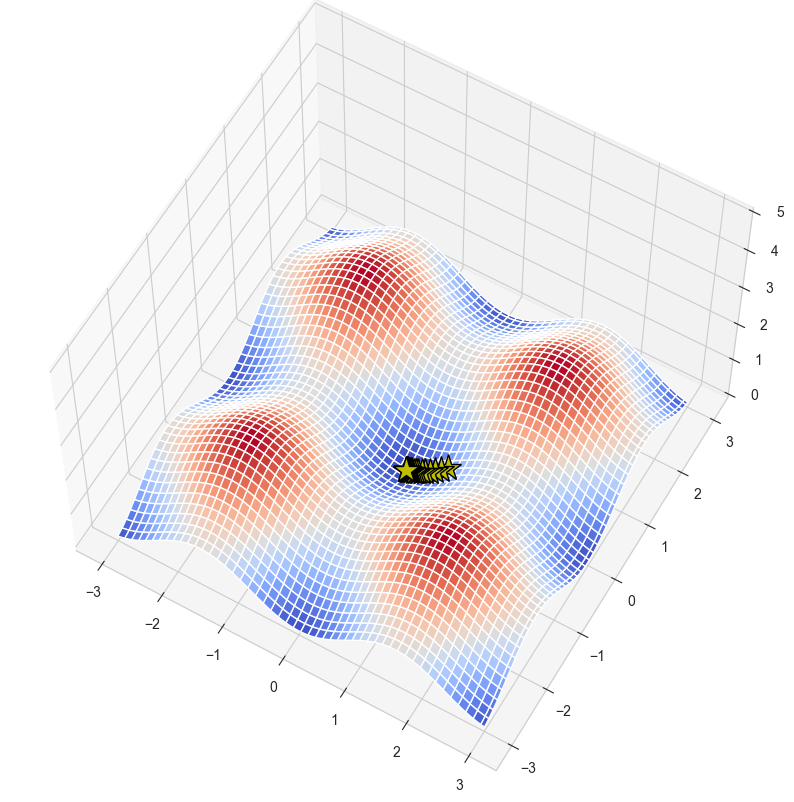

In [13]:
steps = gradient_desc_vis(f, grad_f)

Let's look at the dependence of the value of the function on the gradient descent step.

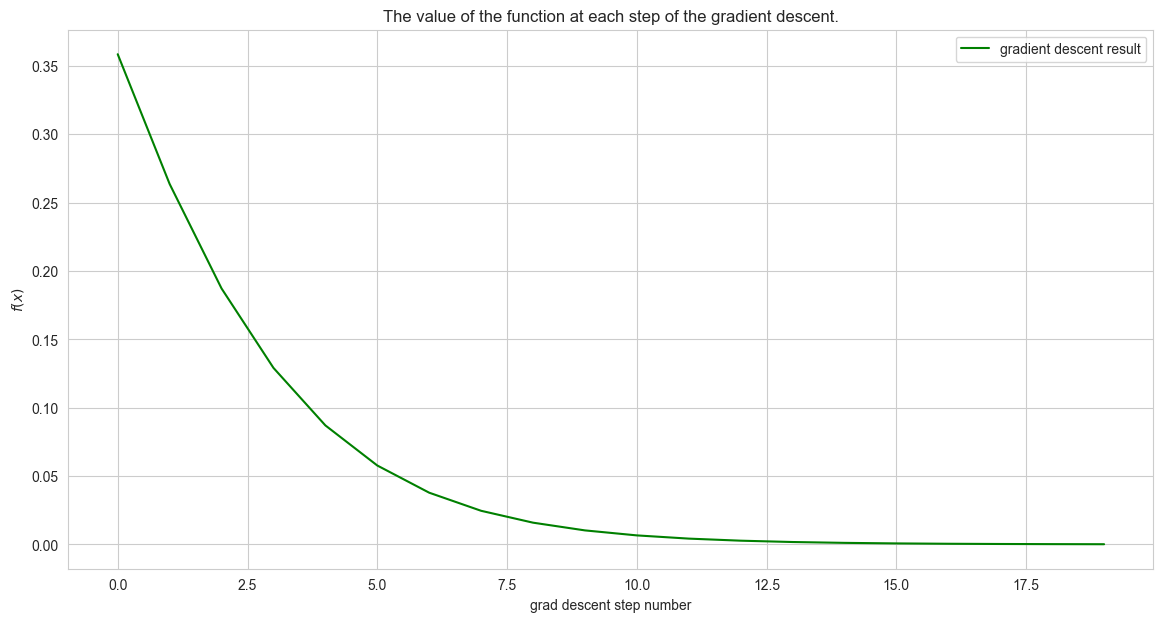

In [14]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("The value of the function at each step of the gradient descent.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result", color='green')
plt.legend();

### Task 2. Implementation of linear regression

Since we will be using gradient descent to train the model, the important part is to implement the loss function and the function to calculate its gradient. Before starting, it is worth recalling how to calculate the MSE gradient. The derivation of this formula can be found [here](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
     MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
     \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

This is where matrix multiplication comes into play.

#### Task 2.1. MSE and its gradient

In [15]:
def mse(y_true, y_pred):
    """
    Loss function MSE.
         :param y_true: np.array[n_samples]: vector of correct answers
         :param y_pred: np.array[n_samples]: vector from model predictions
         :return: loss function value
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    mse_res = np.square(y_true - y_pred).mean()
        
    return mse_res


def mse_grad(y_true, y_pred, X):
    """
    Function for calculating the MSE gradient.
         :param y_true: np.array[n_samples]: vector of correct answers
         :param y_pred: np.array[n_samples]: vector from model predictions
         :param X: np.array[n_samples, n_features]: matrix of objects x features
         :return: gradient of MSE loss function
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    
    grad = 2 * (X.T @ (y_pred - y_true))/y_true.shape[0]
    
    return grad


class MSELoss:
    """
    A class that implements the MSE loss function. Needed in order to
    combine the loss function and the gradient for it in one place.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

We will use the following class to calculate the gradient of our loss functions:

In [16]:
class BasicGradientDescent:
    """
    A class that allows you to do gradient descent steps, 
    as well as calculating the gradient norm.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

In this task, you will need to implement linear regression and train it using gradient descent. To begin with, we will implement a base class for all linear models, from which we will then inherit when implementing linear and logistic regressions.

In [17]:
class BaseLinearModel:
    """
    A class that represents a basic linear model, inheriting from which we will
    implement linear and logistic regression.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
         The constructor of our class.
             :param learning_rate: learning rate
             :param loss_function: loss function (MSE or cross entropy)
             :param fit_intercept: do we need to include free terms in the model
             :param n_iter: number of gradient descent iterations
             :param tol: parameter to stop gradient descent,
                         if the norm of the gradient (l1 or l2) is less than tol, then we stop
             :param optimizer: class that will calculate the gradient and its norm
             :param grad_norm: gradient norm type l1 or l2
         """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # params are not set at the beginning
        self.W = None
        
        
    def fit(self, X, y):
        """
        Method for training our model
             :param X: matrix objects x features
             :param y: vector of target variable values
             :return: trained model
        """
        
        # Let's make y a column vector (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Let's add a column of 1 to matrix X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Initializing the model weights
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Training the model using gradient descent
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # If the gradient is close to 0, we stop
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Task 2.2. Linear Regression Predictions

Implement the `predict` method for the `CustomLinearRegression` class.

In [18]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Method for calculating predictions
             :param X_test: np.array[n_test_samples, n_features]:
                            matrix of objects x features (test dataset)
             :return: y_pred: np.array[n_test_samples, 1]: model predictions
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### I'll check our implementation with a simple example

In [19]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

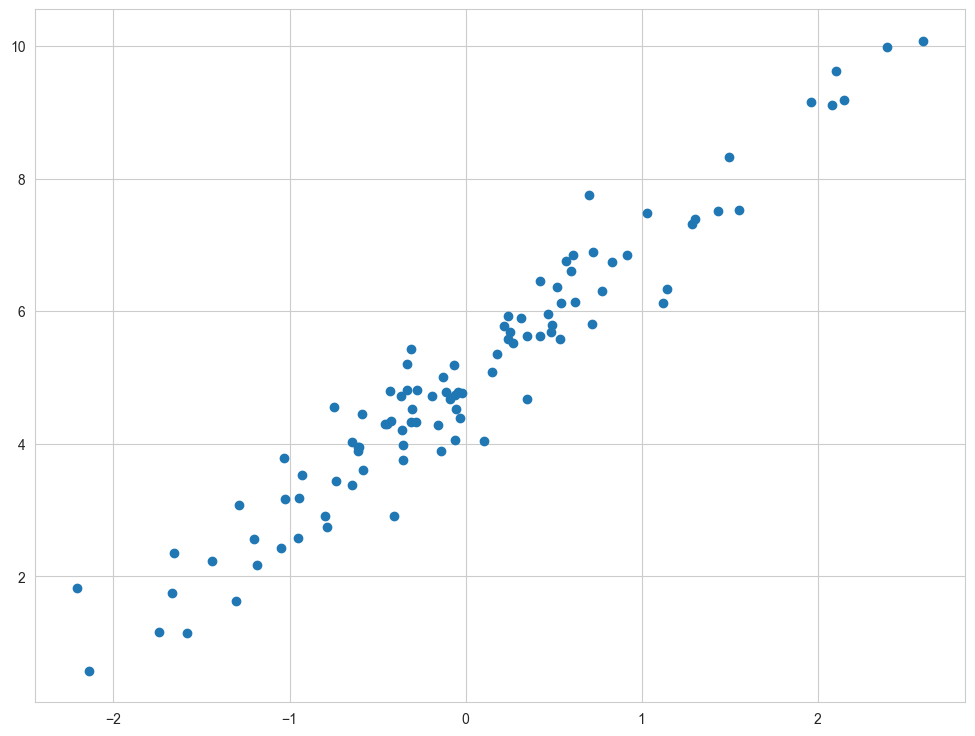

In [20]:
plt.scatter(X, y);

In [21]:
custom_lin_reg = CustomLinearRegression()

In [22]:
custom_lin_reg.fit(X, y)

My custom linear regression

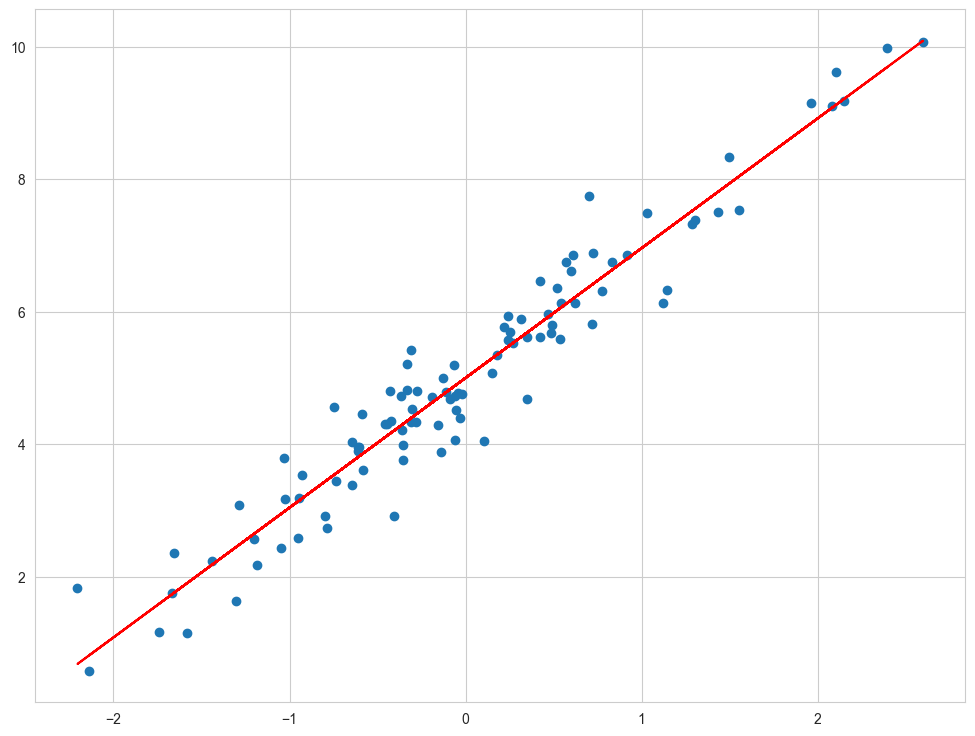

In [23]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X), color='red');

#### Task 2.3. Using built-in linear regression

Let's work with data on home prices in Boston. Build a linear regression model using `LinearRegression` from `sklearn`. Don't forget to divide the data into training and test parts, and also properly preprocess the features. At the end, use some of the regression metrics you have studied and draw conclusions about the quality of the resulting model, as well as which features are most important from the point of view of the resulting model..

In [24]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

Let's look at features dataframe

In [25]:
x_df = pd.DataFrame(X,columns = feature_names)
x_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [26]:
x_df.dtypes, x_df.isnull().values.any()

(CRIM       float64
 ZN         float64
 INDUS      float64
 CHAS       float64
 NOX        float64
 RM         float64
 AGE        float64
 DIS        float64
 RAD        float64
 TAX        float64
 PTRATIO    float64
 B          float64
 LSTAT      float64
 dtype: object,
 False)

In [27]:
x_df.mean(), x_df.std()

(CRIM         3.613524
 ZN          11.363636
 INDUS       11.136779
 CHAS         0.069170
 NOX          0.554695
 RM           6.284634
 AGE         68.574901
 DIS          3.795043
 RAD          9.549407
 TAX        408.237154
 PTRATIO     18.455534
 B          356.674032
 LSTAT       12.653063
 dtype: float64,
 CRIM         8.601545
 ZN          23.322453
 INDUS        6.860353
 CHAS         0.253994
 NOX          0.115878
 RM           0.702617
 AGE         28.148861
 DIS          2.105710
 RAD          8.707259
 TAX        168.537116
 PTRATIO      2.164946
 B           91.294864
 LSTAT        7.141062
 dtype: float64)

Data is not standartized

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mylinear = LinearRegression()
mylinear.fit(X_train, y_train)
pred = mylinear.predict(X_test)

In [29]:
r2 = r2_score(y_test,pred)
y_mean = np.full(y_test.size,y_test.mean())
mse_rel = mean_squared_error(y_test, y_mean)/mean_squared_error(y_test,pred)
f'{r2 = }   {mse_rel = } '

'r2 = 0.7456651065331112   mse_rel = 3.9318238499200975 '

1. The coefficient of determination is not the worst, the model predicts something
2. MSE - for our model mse is almost four times less than for the average. Predicts something

In [30]:
pd.DataFrame(abs(mylinear.coef_), index=feature_names,columns=['coef']).sort_values(by='coef',
                                                                                    ascending=False)


,coef
LSTAT,3.702451
DIS,2.997818
RM,2.618812
RAD,2.399244
TAX,2.033689
PTRATIO,1.920882
NOX,1.862857
ZN,1.162808
B,0.990977
CHAS,0.652732


Features are sorted in descending order of their importance, their influence on the target variable

### Task 3. Implementation of logistic regression

Logistic regression is not very different from ordinary linear regression and is used in classification tasks. Since here we will again use gradient descent, we need to define the loss function and its gradient. One of the most popular options in the binary classification problem is binary cross entropy (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i) )\right].$$

where $y$ is the target of the desired result and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) that converts a real number $\mathbb R$ into a probability $[0,1]$.

The only problem with this function iposibilitybility to get 0 under the logarithm sign, which is not very good. Let's try to deal with this head-on. Let's say that our predictions can take values from 0 + eps to 1 - eps, where eps is a very small number.

#### Task 3.1. Implementation of sigmoid 

Implement a function `sigmoid` that converts a real number $\mathbb R$ to a probability $[0,1]$..

In [56]:
def sigmoid(output):
    # output X@w (-inf, +inf)
    """Sigmoid function"""
    prob = 1 / (np.exp(- output) + 1)
    return prob

#### Task 3.2. BCE Loss and its gradient


Since you and I are just starting to study machine learning, it would be too harsh to ask you to calculate the BCE Loss gradient (it’s not that complicated, it just takes some getting used to). Therefore, let’s immediately write a formula for it:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [58]:
def bce(y_true, y_pred, eps=1e-15):
    """
    BCE loss function.
         :param y_true: np.array[n_samples]: vector of correct answers 0/1
         :param y_pred: np.array[n_samples]: vector of model predictions (probabilities)
         :return: loss function value
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
           
    bce = np.sum(y_true * np.log(sigmoid(y_pred)) + (1 - y_true) * np.log(1 - sigmoid(y_pred)))/(- n)
           
    return bce
    

def bce_grad(y_true, y_pred, X):
    """
    BCE loss function.
         :param y_true: np.array[n_samples]: vector of correct answers 0/1
         :param y_pred: np.array[n_samples]: vector of model predictions (probabilities)
         :param X: np.array[n_samples, n_features]: matrix of objects x features
         :return: loss function value
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    BCE_g = X.T @ (y_pred - y_true)
    return BCE_g


class BCELoss:
    """
    A class that implements the BCE loss function. Needed in order to
    combine the loss function and the gradient for it in one place.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Task 3.3. Logistic regression predictions

Implement the `predict` method for the `CustomLogisticRegression` class, don't forget about the free member!

In [59]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        pred = sigmoid(X_test @ self.W).round() # порог 0,5
        return pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Let's check the operation of the algorithm again using a simple example.

In [60]:
# Let's create a dataset of 1 feature and 2 classes
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

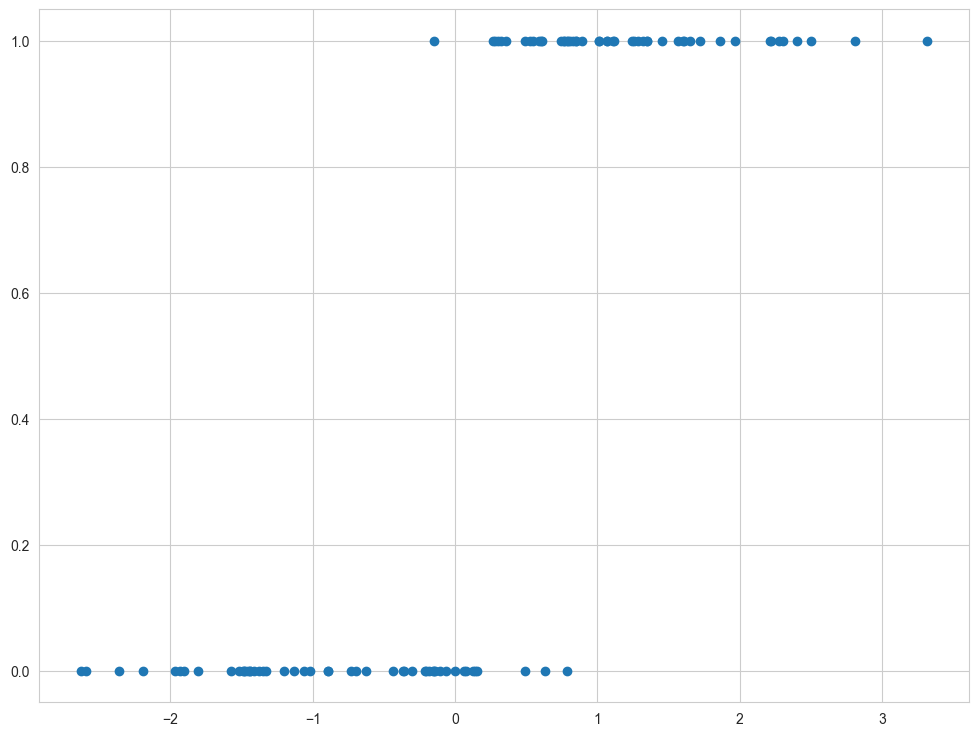

In [61]:
plt.scatter(X, y);

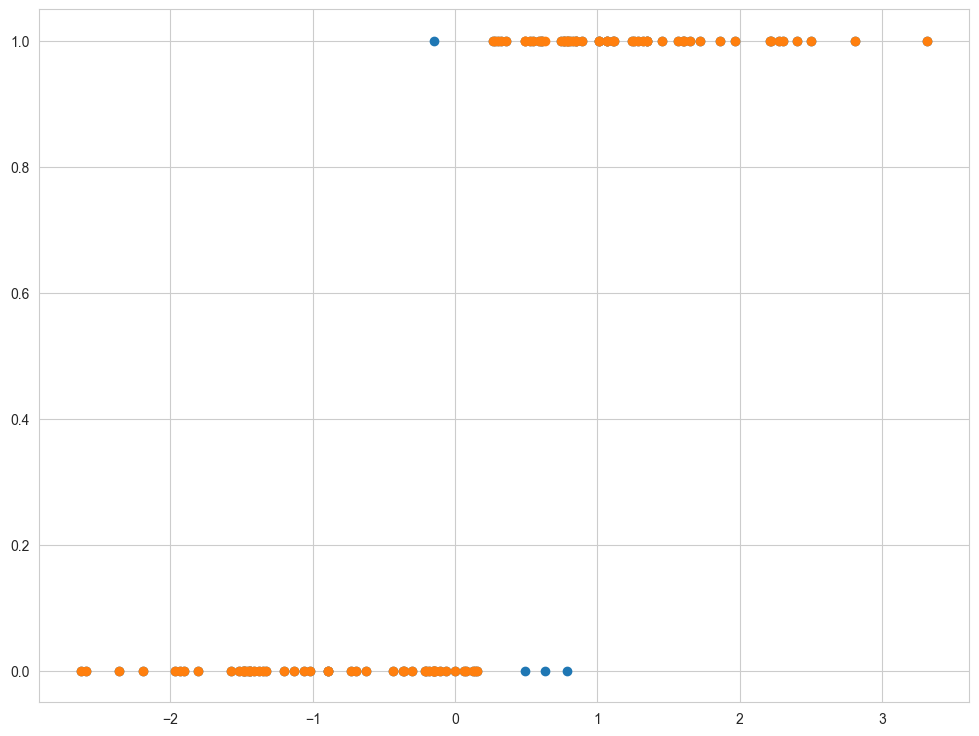

In [62]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)
y_pred2 = log_reg.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
# plt.scatter(X, y_pred2)

Test your model's performance using the binary classification metrics you know.

In [63]:
f'{roc_auc_score(y, y_pred) = }'

'roc_auc_score(y, y_pred) = 0.96'

In [64]:
accuracy_score(y, y_pred)

0.96

In [65]:
log_loss(y, y_pred)

1.4417461355646861

Quite good. However, everything strongly depends on the generation of the dataset

#### Task 3.4. Applying logistic regression

We will use data on Pokemon properties (https://www.kaggle.com/abcsds/pokemon). In this assignment, you first need to do a short EDA (Look at the data and its distributions, and see how various features are related to each other and to the target variable (`Legendary`)).

In [66]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [67]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [68]:
for col in pokemon.columns:
    print(f'___________{col}____________')
    print(pokemon[col].value_counts())
    print('______________________________')

___________#____________
#
479    6
386    4
710    4
711    4
646    3
      ..
250    1
251    1
252    1
253    1
721    1
Name: count, Length: 721, dtype: int64
______________________________
___________Name____________
Name
Bulbasaur              1
Uxie                   1
GalladeMega Gallade    1
Probopass              1
Dusknoir               1
                      ..
Lugia                  1
Ho-oh                  1
Celebi                 1
Treecko                1
Volcanion              1
Name: count, Length: 800, dtype: int64
______________________________
___________Type 1____________
Type 1
Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: count, dtype: int64
______________________________
___________Type 2____________
Type 2
Flying 

In [69]:
pokemon[pokemon['#']==646]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
710,646,Kyurem,Dragon,Ice,660,125,130,90,130,90,95,5,True
711,646,KyuremBlack Kyurem,Dragon,Ice,700,125,170,100,120,90,95,5,True
712,646,KyuremWhite Kyurem,Dragon,Ice,700,125,120,90,170,100,95,5,True


Let's throw away Type 2 - a lot of NA. Let's throw out the names - they are unique. # - throw it away, they are practically unique. It is not entirely clear whether it was worth throwing out duplicates by number - these are almost identical Pokemon, their presence may shift the result. Type1 - to OHE, Legendary - to boolean. Total - looks like a dependent variable. If yes, remove it. Data in general - standardize

In [70]:
pokemon.iloc[:,5:11].sum().sum() - pokemon.iloc[:,4].sum()

0

Indeed - `total` is a sum of the next 6 columns


In [71]:
y = pokemon["Legendary"].astype(int).values

pokemon_proc = pokemon.drop(['#','Name','Type 2', 'Total','Legendary'], axis=1)

X = pd.get_dummies(pokemon_proc, columns=["Type 1"])

Divide your data into a test set and a training set.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

divided into train/test and standardized

Train a `LogisticRegression` model from `sklearn`.

In [75]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

Print your classifier metrics:

1. Draw a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Draw the ROC curve and calculate the area under it.

3. Tell me which features were most important for the model.

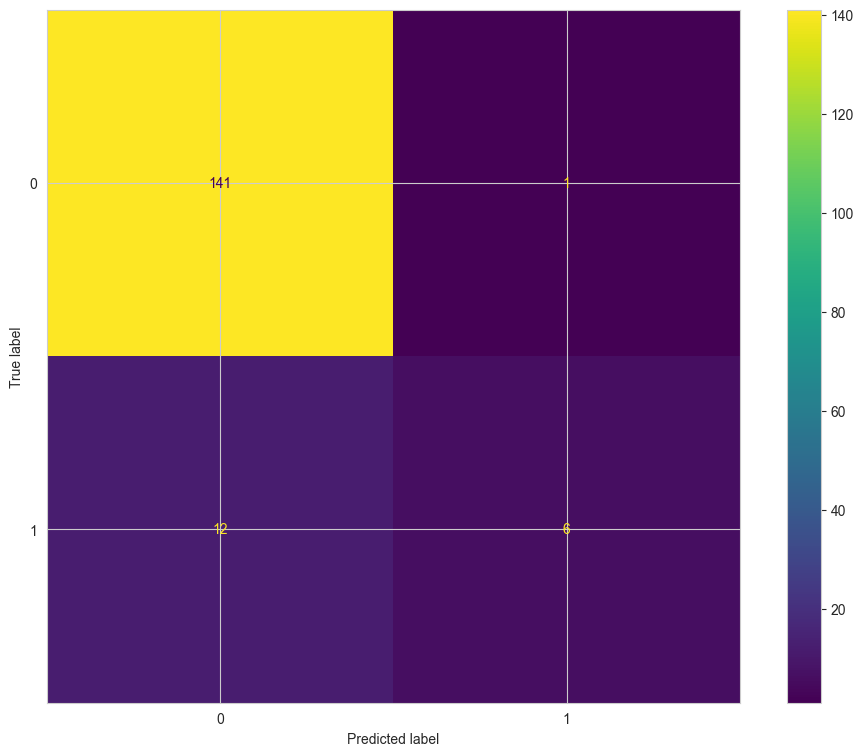

In [82]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

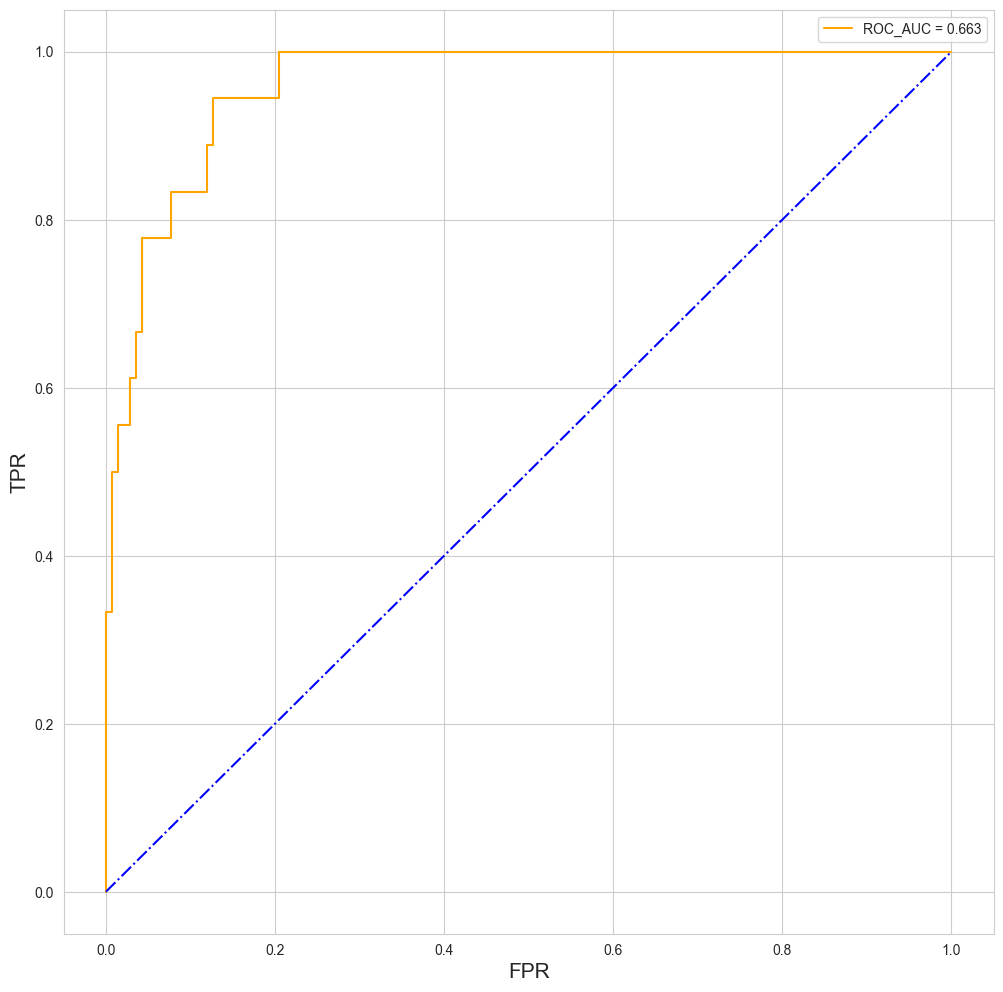

In [77]:
y_score = logreg.decision_function(X_test)
ROC_AUC = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(12,12))
plt.plot(fpr, tpr,'orange', label=f'{ROC_AUC = :.3f}')
plt.plot([0, 1], [0, 1],'blue', linestyle='-.')
plt.ylabel('TPR', fontsize=15)
plt.xlabel('FPR', fontsize=15)
plt.legend()


In [78]:
feature_role = pd.DataFrame(abs(logreg.coef_[0]), index=X.columns, columns=['coef']).sort_values(by='coef',
                                                                                    ascending=False)
feature_role

,coef
Speed,1.410639
Sp. Atk,1.268287
Sp. Def,1.236693
Defense,1.009774
Generation,0.986811
HP,0.877422
Attack,0.728832
Type 1_Water,0.611269
Type 1_Ground,0.479176
Type 1_Bug,0.464410


Something tells me that the top of the list may not be the most important features after all.